###  Libraries

In [8]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

from tslearn.clustering import KernelKMeans

from KernelKMeansPP import KernelKMeansPP
from Rings import Rings

### Global Variables

In [9]:
seed = 42

### Load Dataset

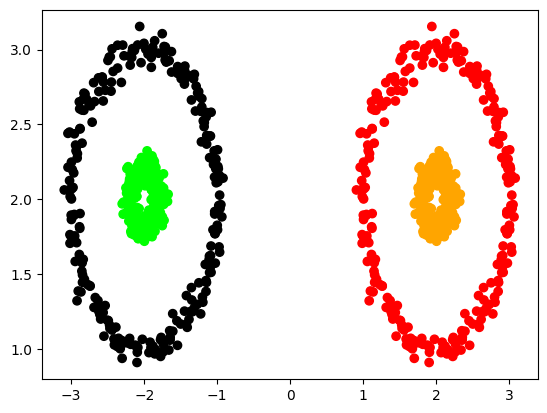

In [10]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

# Generate 5 pairs of data with specified center positions and unique IDs for each ring
centers_coordinates = [(2, 2), (-2, 2)]  # Specify center positions for each pair

rings = Rings()

X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=500, factor=0.2, noise=0.05)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors))

In [11]:
K = 4
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=3)

### kMeans

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikit_learn-1.3.1-py3.11-win-amd64.egg\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


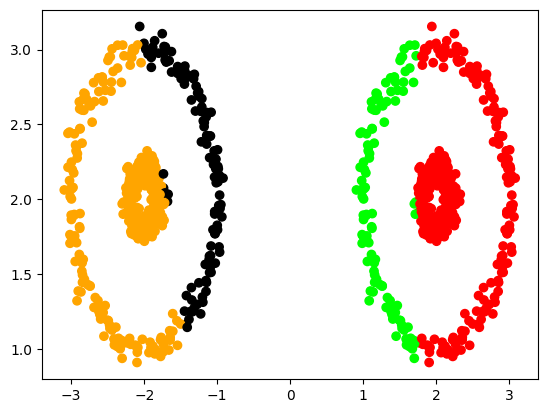

In [12]:
kmeans = KMeans(n_clusters=K).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=ListedColormap(colors))

### Kernel kMeans

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1000 1-dimensional timeseries
  warnings.warn(


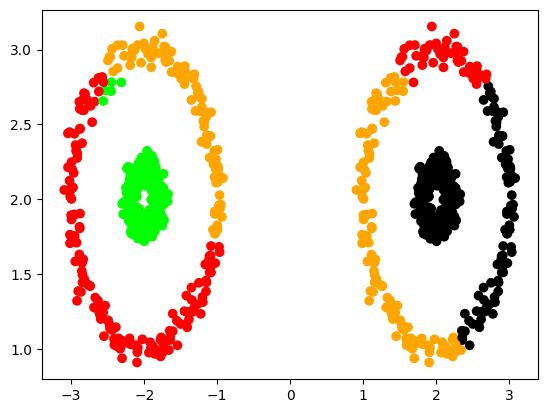

In [13]:
# Should find a way to init the fucking centers!
kernel_kmeans = KernelKMeans(n_clusters=K, n_init=1, kernel='precomputed').fit(kernel_matrix)
plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_, cmap=ListedColormap(colors))
plt.show()

### Kernel kMeans++

Executing KkMeans++ Initialization

 Finished in 8 iterations!

 Total Error is: 595.4302529102293!
Executing KkMeans++ Initialization

 Finished in 5 iterations!

 Total Error is: 525.7379651553601!
Executing KkMeans++ Initialization

 Finished in 5 iterations!

 Total Error is: 595.697725720043!
Executing KkMeans++ Initialization

 Finished in 8 iterations!

 Total Error is: 525.7379651553601!
Executing KkMeans++ Initialization

 Finished in 11 iterations!

 Total Error is: 525.7379651553601!
Executing KkMeans++ Initialization

 Finished in 6 iterations!

 Total Error is: 525.7379651553601!
Executing KkMeans++ Initialization

 Finished in 5 iterations!

 Total Error is: 595.5870412823112!
Executing KkMeans++ Initialization

 Finished in 7 iterations!

 Total Error is: 595.7243878654508!
Executing KkMeans++ Initialization

 Finished in 6 iterations!

 Total Error is: 530.1117382612923!
Executing KkMeans++ Initialization

 Finished in 6 iterations!

 Total Error is: 525.7379651553601!


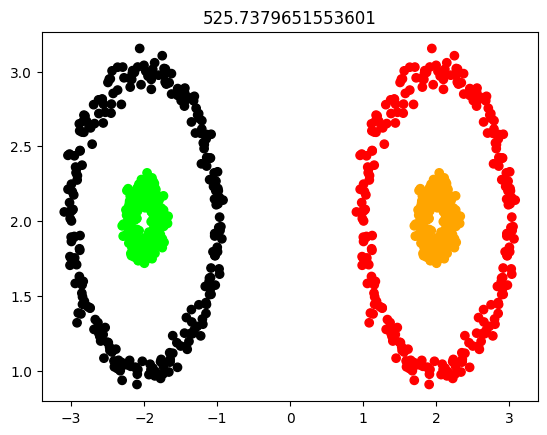

In [17]:
kernelKMeansPP =  KernelKMeansPP()
min_total_error, best_partition = kernelKMeansPP.kernel_kmeans_pp(X, K, kernel_matrix, n_init=10, method='KkMeans++')
plt.scatter(X[:, 0], X[:, 1], c=best_partition, cmap=ListedColormap(colors))
plt.title(min_total_error)
plt.show()